# Graph class

While studying the model initialization, an important part is the Graph. Called for the first time on [1], the Graph module init for the construction of the Graph.

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/modulus/models/graphcast/graph_cast_net.py#L308

In [1]:
%run review/__common.py
%load_ext autoreload
%autoreload 2

[W1228 13:54:13.324528748 Utils.hpp:135] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function operator())


In [2]:
from modulus.utils.graphcast.icosahedral_mesh import (
    faces_to_edges,
    get_hierarchy_of_triangular_meshes_for_sphere,
    merge_meshes,
)

from modulus.utils.graphcast.graph_utils import (
    add_edge_features,
    add_node_features,
    create_graph,
    create_heterograph,
    get_face_centroids,
    latlon2xyz,
    max_edge_length,
    xyz2latlon,
    geospatial_rotation
)

from sklearn.neighbors import NearestNeighbors

## init

```python
    """
    Graph class for creating the graph2mesh, latent mesh, and mesh2graph graphs.
    """
```

The constructor is defined in [1], and invokation by the GraphCastNet module init [2].

- [1] https://vscode.dev/github/NVIDIA/modulus/blob/main/modulus/utils/graphcast/graph.py#L67
- [2] https://vscode.dev/github/NVIDIA/modulus/blob/main/modulus/models/graphcast/graph_cast_net.py#L308

In [3]:
# Setting the __init__ parameters

# re-create the lat_lon_grid var passed on to the constructor from the model
input_res: tuple = (721, 1440)
latitudes = torch.linspace(-90, 90, steps=input_res[0])
longitudes = torch.linspace(-180, 180, steps=input_res[1] + 1)[1:]
lat_lon_grid = torch.stack(torch.meshgrid(latitudes, longitudes, indexing="ij"), dim=-1)

# Other parameters
mesh_level: int = 6
multimesh: bool = True
khop_neighbors: int = 0
dtype = torch.float

Part of the init body:

In [4]:
# flatten lat/lon gird
lat_lon_grid_flat = lat_lon_grid.permute(2, 0, 1).view(2, -1).permute(1, 0)
lat_lon_grid.shape, lat_lon_grid_flat.shape, lat_lon_grid_flat[:2]

(torch.Size([721, 1440, 2]),
 torch.Size([1038240, 2]),
 tensor([[ -90.0000, -179.7500],
         [ -90.0000, -179.5000]]))

In [5]:
# create the multi-mesh
_meshes = get_hierarchy_of_triangular_meshes_for_sphere(splits=mesh_level)
len(_meshes)

7

In [6]:
finest_mesh = _meshes[-1]
finest_mesh_src, finest_mesh_dst = faces_to_edges(finest_mesh.faces)
finest_mesh_vertices = np.array(finest_mesh.vertices)

if multimesh: # True
    mesh = merge_meshes(_meshes)
    mesh_src, mesh_dst = faces_to_edges(mesh.faces)
    mesh_vertices = np.array(mesh.vertices)
else:
    pass
    # mesh = finest_mesh
    # mesh_src, mesh_dst = finest_mesh_src, finest_mesh_dst
    # mesh_vertices = finest_mesh_vertices
mesh_faces = mesh.faces

In [143]:
len(mesh_faces)

109220

## create_mesh_graph()

```python
"""Create the multimesh graph."""
```

In [89]:
mesh_graph = create_graph(
    mesh_src,
    mesh_dst,
    to_bidirected=True,
    add_self_loop=False,
    dtype=torch.int32,
)

mesh_pos = torch.tensor(
    mesh_vertices,
    dtype=torch.float32,
)

In [90]:
mesh_graph = add_edge_features(mesh_graph, mesh_pos)
mesh_graph = add_node_features(mesh_graph, mesh_pos)
mesh_graph.ndata["lat_lon"] = xyz2latlon(mesh_pos)


In [91]:
print("Edge info:")
for k in mesh_graph.edata.keys():
    print(k, mesh_graph.edata[k].shape)

Edge info:
x torch.Size([327660, 4])


**Comment:** "x" contains: the first 3 columns contains, for each edge, the displacement vector from source to destination. The 4th columns is the norm of such vector, thus encoding the distance.

In [92]:
print("Nodes info:")
for k in mesh_graph.ndata.keys():
    print(k, mesh_graph.ndata[k].shape)

Nodes info:
x torch.Size([40962, 3])
lat_lon torch.Size([40962, 2])


**Comment:** "x" contains: cos and sin of the lat/lon coorindates of vertices making up a cilinder-looking shape. "lat_lon" contains a simple `xyz2latlon()` of the 3D vertices.

In [93]:
mesh_graph.ndata["x"].dtype

torch.float32

In [94]:
mesh_graph.ndata["x"] = mesh_graph.ndata["x"].to(dtype=dtype)
mesh_graph.edata["x"] = mesh_graph.edata["x"].to(dtype=dtype)

In [95]:
mesh_graph.ndata["x"].dtype

torch.float32

In [96]:
khop_neighbors

0

In [97]:
if khop_neighbors > 0:
    pass
    # # Make a graph whose edges connect the k-hop neighbors of the original graph.
    # khop_adj_bool = self.khop_adj_all_k(g=mesh_graph, kmax=self.khop_neighbors)
    # mask = ~khop_adj_bool
else:
    mask = None

**Comment:** This function builds the `DGLGraph` graph, and enriches its edges and nodes with information encoding their locality and spatial relationship with other nodes.

[0.49112344 0.8506508  0.18759246]


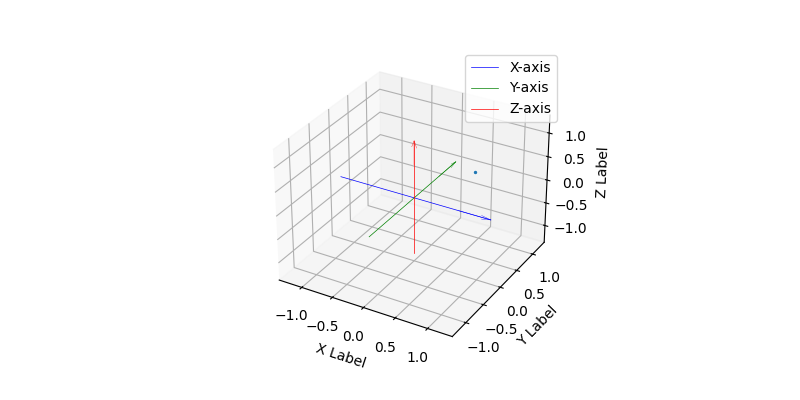

In [127]:
%matplotlib widget

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

# Add thin X, Y, Z axis lines
v_range = [-1.2, 1.2]
ax.plot(v_range, [0, 0], [0, 0], color='blue', linewidth=.5, label='X-axis')
ax.plot([0, 0], v_range, [0, 0], color='green', linewidth=.5, label='Y-axis')
ax.plot([0, 0], [0, 0], v_range, color='red', linewidth=.5, label='Z-axis')

# Add small arrows at the end of each axis
arrow_length = 0.5
arrow_starts = v_range[-1] - arrow_length
ax.quiver(arrow_starts, 0, 0, arrow_length, 0, 0, color='blue', linewidth=.25)
ax.quiver(0, arrow_starts, 0, 0, arrow_length, 0, color='green', linewidth=.25)
ax.quiver(0, 0, arrow_starts, 0, 0, arrow_length, color='red', linewidth=.25)

# Plot data
coarser_mesh = mesh.vertices
print(coarser_mesh[0])
ax.scatter3D(coarser_mesh[0, 0], coarser_mesh[0, 1], coarser_mesh[0, 2], s=2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

#ax.set_aspect('equal')
ax.legend()
plt.show()

In [114]:
mesh_graph.edata["x"].shape

torch.Size([327660, 4])

In [117]:
_indices_of_interest = {}
_src, _dst = mesh_graph.edges()
for i in range(len(_src)):
    if _src[i] == 0:
        _indices_of_interest[int(_dst[i])] = float(mesh_graph.edata["x"][i, 3])
_indices_of_interest

{1: 0.9999998807907104,
 2: 0.9999998807907104,
 4: 0.9999998807907104,
 6: 0.9999998807907104,
 8: 0.9999998807907104,
 12: 0.5197837352752686,
 14: 0.5197837948799133,
 15: 0.5197837948799133,
 17: 0.5197837948799133,
 20: 0.5197837352752686,
 42: 0.26240068674087524,
 44: 0.26240074634552,
 51: 0.2624007761478424,
 61: 0.2624007761478424,
 71: 0.2624007761478424,
 162: 0.13151510059833527,
 164: 0.13151511549949646,
 192: 0.13151514530181885,
 230: 0.13151516020298004,
 266: 0.13151513040065765,
 642: 0.06579691171646118,
 644: 0.06579692661762238,
 750: 0.06579689681529999,
 892: 0.06579696387052536,
 1028: 0.06579694896936417,
 2562: 0.032903365790843964,
 2564: 0.03290336951613426,
 2970: 0.03290339559316635,
 3512: 0.03290342912077904,
 4040: 0.03290339186787605,
 10242: 0.016452332958579063,
 10244: 0.016452305018901825,
 11826: 0.016452325507998466,
 13936: 0.016452331095933914,
 16016: 0.01645231433212757}

In [125]:
coarser_mesh.shape

(1, 3)

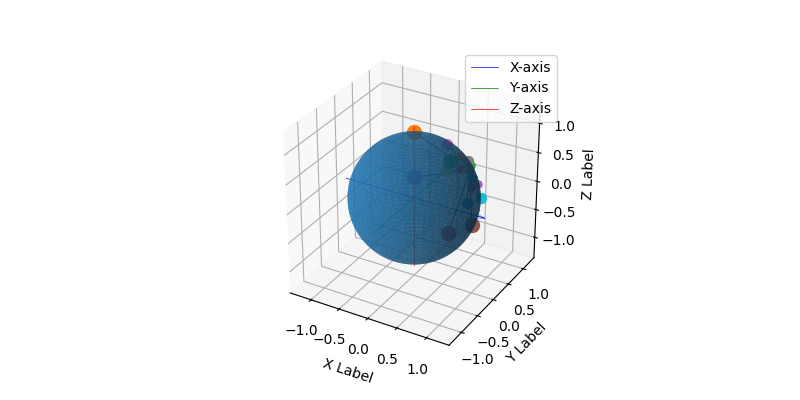

In [136]:
%matplotlib widget

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

# Add thin X, Y, Z axis lines
v_range = [-1.2, 1.2]
ax.plot(v_range, [0, 0], [0, 0], color='blue', linewidth=.5, label='X-axis')
ax.plot([0, 0], v_range, [0, 0], color='green', linewidth=.5, label='Y-axis')
ax.plot([0, 0], [0, 0], v_range, color='red', linewidth=.5, label='Z-axis')

# Add small arrows at the end of each axis
arrow_length = 0.5
arrow_starts = v_range[-1] - arrow_length
ax.quiver(arrow_starts, 0, 0, arrow_length, 0, 0, color='blue', linewidth=.25)
ax.quiver(0, arrow_starts, 0, 0, arrow_length, 0, color='green', linewidth=.25)
ax.quiver(0, 0, arrow_starts, 0, 0, arrow_length, color='red', linewidth=.25)

# Plot data
coarser_mesh = mesh.vertices
ax.scatter3D(coarser_mesh[0, 0], coarser_mesh[0, 1], coarser_mesh[0, 2], s=20)

for k, v in _indices_of_interest.items():
    ax.scatter3D(coarser_mesh[k, 0], coarser_mesh[k, 1], coarser_mesh[k, 2], s=v*100)
    start = coarser_mesh[0]
    end = coarser_mesh[k]
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color='black', linewidth=.5)

# Plot sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, alpha=0.7, edgecolor='none', shade=True)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_aspect('equal')
ax.legend()
plt.show()

## create_g2m_graph(...)

```python
"""Create the graph2mesh graph."""
```

In [16]:
max_edge_len = max_edge_length(
    finest_mesh_vertices, finest_mesh_src, finest_mesh_dst
)

max_edge_len

0.02067309

In [69]:
_lat_lon_grid_flat = lat_lon_grid_flat[:50000, :]

In [70]:
cartesian_grid = latlon2xyz(_lat_lon_grid_flat)

cartesian_grid, cartesian_grid.shape

(tensor([[ 4.3711e-08,  1.9072e-10, -1.0000e+00],
         [ 4.3710e-08,  3.8144e-10, -1.0000e+00],
         [ 4.3708e-08,  5.7216e-10, -1.0000e+00],
         ...,
         [ 2.6936e-02,  1.4533e-01, -9.8902e-01],
         [ 2.6302e-02,  1.4545e-01, -9.8902e-01],
         [ 2.5667e-02,  1.4556e-01, -9.8902e-01]]),
 torch.Size([50000, 3]))

/tmp/ipykernel_446/2668278548.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


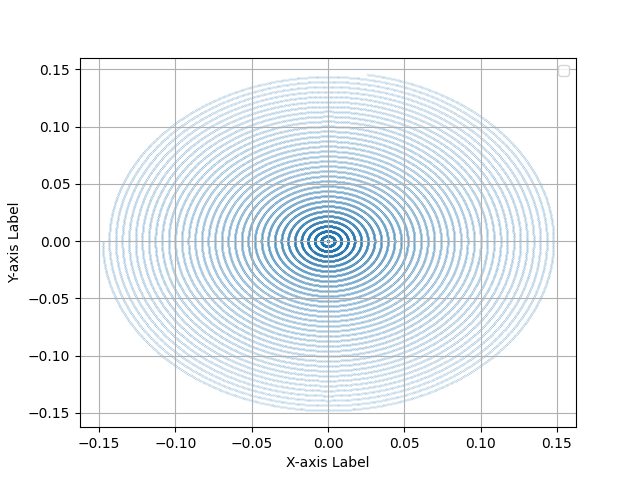

In [71]:
%matplotlib widget

plt.figure()
plt.scatter(cartesian_grid[:, 0], cartesian_grid[:, 1], s=0.01, alpha=0.7)
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

**Comment:** The 2D grid is projected in 3D space maintaining the high density of points for the poles. This is necessary to project back to 2D space?

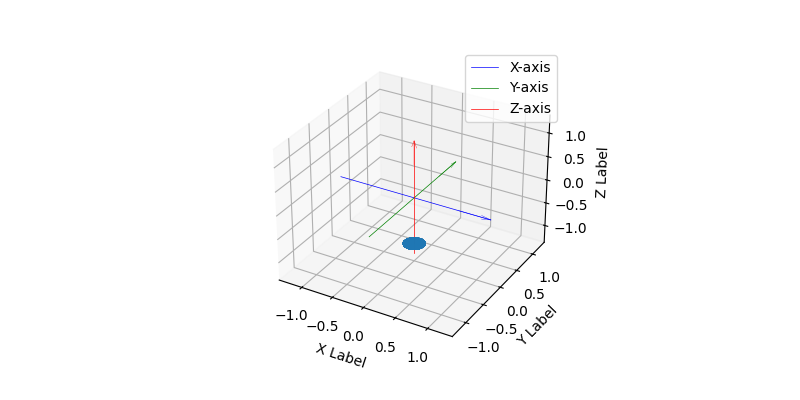

In [20]:
%matplotlib widget

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

# Add thin X, Y, Z axis lines
v_range = [-1.2, 1.2]
ax.plot(v_range, [0, 0], [0, 0], color='blue', linewidth=.5, label='X-axis')
ax.plot([0, 0], v_range, [0, 0], color='green', linewidth=.5, label='Y-axis')
ax.plot([0, 0], [0, 0], v_range, color='red', linewidth=.5, label='Z-axis')

# Add small arrows at the end of each axis
arrow_length = 0.5
arrow_starts = v_range[-1] - arrow_length
ax.quiver(arrow_starts, 0, 0, arrow_length, 0, 0, color='blue', linewidth=.25)
ax.quiver(0, arrow_starts, 0, 0, arrow_length, 0, color='green', linewidth=.25)
ax.quiver(0, 0, arrow_starts, 0, 0, arrow_length, color='red', linewidth=.25)

# Plot data
ax.scatter3D(cartesian_grid[:, 0], cartesian_grid[:, 1], cartesian_grid[:, 2], s=.2)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

#ax.set_aspect('equal')
ax.legend()
plt.show()

In [21]:
cartesian_grid = latlon2xyz(lat_lon_grid_flat)

In [22]:
n_nbrs = 4
neighbors = NearestNeighbors(n_neighbors=n_nbrs).fit(mesh_vertices)
distances, indices = neighbors.kneighbors(cartesian_grid)

In [23]:
distances, distances.shape

(array([[0.01193578, 0.01193578, 0.01193584, 0.02386773],
        [0.01193578, 0.01193578, 0.01193584, 0.02386773],
        [0.01193578, 0.01193578, 0.01193584, 0.02386773],
        ...,
        [0.01193576, 0.01193582, 0.01193582, 0.02386775],
        [0.01193576, 0.01193582, 0.01193582, 0.02386775],
        [0.01193576, 0.01193582, 0.01193582, 0.02386775]]),
 (1038240, 4))

In [24]:
indices, indices.shape

(array([[28832, 28833, 28831,  7249],
        [28832, 28833, 28831,  7249],
        [28832, 28833, 28831,  7249],
        ...,
        [21105, 21104, 21103,  5305],
        [21105, 21104, 21103,  5305],
        [21105, 21103, 21104,  5303]]),
 (1038240, 4))

In [25]:
mesh_vertices, mesh_vertices.shape

(array([[ 0.49112344,  0.8506508 ,  0.18759246],
        [-0.303531  ,  0.5257311 ,  0.7946544 ],
        [ 0.607062  ,  0.        ,  0.7946544 ],
        ...,
        [-0.75296974,  0.56828874,  0.3317899 ],
        [-0.73962533,  0.57862514,  0.3437255 ],
        [-0.7433136 ,  0.5850135 ,  0.32441333]], dtype=float32),
 (40962, 3))

In [32]:
src, dst = [], []
for i in range(len(cartesian_grid)):
    for j in range(n_nbrs):
        if distances[i][j] <= 0.6 * max_edge_len:
            src.append(i)
            dst.append(indices[i][j])

In [35]:
from collections import defaultdict
src_count = defaultdict(int)
dst_count = defaultdict(int)
for i in range(len(src)):
    src_count[src[i]] += 1
    dst_count[dst[i]] += 1

In [43]:
set(src_count.values()), set(dst_count.values())

({1, 2, 3},
 {23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  105,
  106,
  107,
  108,
  109,
  110,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  121,
  122,
  123,
  124,
  127,
  128,
  130,
  132,
  133,
  136,
  138,
  140,
  141,
  142,
  145,
  146,
  151,
  157,
  160,
  161,
  162,
  164,
  166,
  171,
  172,
  176,
  177,
  179,
  180,
  188,
  198,
  202,
  207,
  217,
  219,
  225,
  226,
  232,
  250,
  266,
  268,
  278,
  294,
  295,
  308,
  314,
  364,
  378,
  417,
  440,
  470,
  515,
  570,
  827,
  1146,
  3753})

In [ ]:
for k, v in dst_count.items():
    if v == 3753:
        print(k, v)

28832 3753
28833 3753
28831 3753
21104 3753
21105 3753
21103 3753


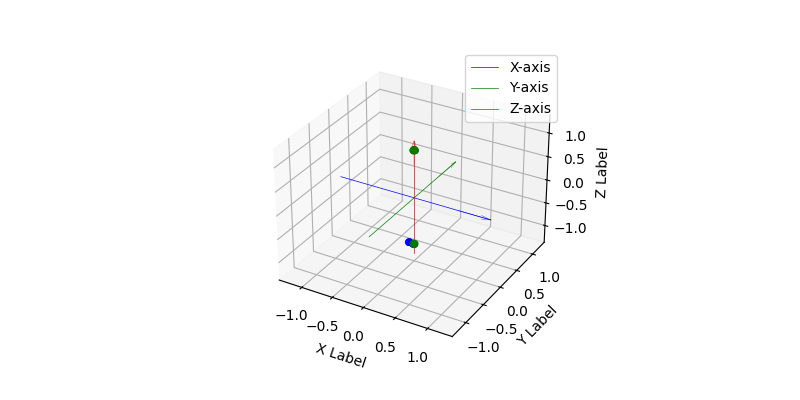

In [193]:
%matplotlib widget

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

# Add thin X, Y, Z axis lines
v_range = [-1.2, 1.2]
ax.plot(v_range, [0, 0], [0, 0], color='blue', linewidth=.5, label='X-axis')
ax.plot([0, 0], v_range, [0, 0], color='green', linewidth=.5, label='Y-axis')
ax.plot([0, 0], [0, 0], v_range, color='red', linewidth=.5, label='Z-axis')
# Add small arrows at the end of each axis
arrow_length = 0.5
arrow_starts = v_range[-1] - arrow_length
ax.quiver(arrow_starts, 0, 0, arrow_length, 0, 0, color='blue', linewidth=.25)
ax.quiver(0, arrow_starts, 0, 0, arrow_length, 0, color='green', linewidth=.25)
ax.quiver(0, 0, arrow_starts, 0, 0, arrow_length, color='red', linewidth=.25)

# Plot data
src_indices = []
dst_indices = []
for i in range(len(src)):
    if dst[i] in [28832, 28833, 28831, 21104, 21105,21103]:
        src_indices.append(src[i])
        dst_indices.append(dst[i])

src_points = cartesian_grid[src_indices]
dst_points = mesh_vertices[dst_indices]

ax.scatter3D(src_points[:, 0], src_points[:, 1], src_points[:, 2], color='blue')
ax.scatter3D(dst_points[:, 0], dst_points[:, 1], dst_points[:, 2], color='green')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

#ax.set_aspect('equal')
ax.legend()
plt.show()

In [45]:
# invoked as: g2m_graph = create_heterograph(src, dst, ("grid", "g2m", "mesh"), dtype=torch.int32)
# defined as: def create_heterograph(
#     src: List,
#     dst: List,
#     labels: str,
#     dtype: torch.dtype = torch.int32,
#     num_nodes_dict: dict = None,
# ) -> DGLGraph:
#   graph = dgl.heterograph(
#     {labels: ("coo", (src, dst))}, num_nodes_dict=num_nodes_dict, idtype=dtype
#   )
#   return graph


# just a wrapper for dgl.heterograph creation
g2m_graph = create_heterograph(
    src, dst, ("grid", "g2m", "mesh"), dtype=torch.int32
)
# becomes:
# graph = dgl.heterograph({("grid", "g2m", "mesh"): ("coo", (src, dst))}, num_nodes_dict=None, idtype=torch.int32)

{("grid", "g2m", "mesh"): ("coo", (src, dst))}

{('grid', 'g2m', 'mesh'): ('coo',
  ([0,
    0,
    0,
    1,
    1,
    1,
    2,
    2,
    2,
    3,
    3,
    3,
    4,
    4,
    4,
    5,
    5,
    5,
    6,
    6,
    6,
    7,
    7,
    7,
    8,
    8,
    8,
    9,
    9,
    9,
    10,
    10,
    10,
    11,
    11,
    11,
    12,
    12,
    12,
    13,
    13,
    13,
    14,
    14,
    14,
    15,
    15,
    15,
    16,
    16,
    16,
    17,
    17,
    17,
    18,
    18,
    18,
    19,
    19,
    19,
    20,
    20,
    20,
    21,
    21,
    21,
    22,
    22,
    22,
    23,
    23,
    23,
    24,
    24,
    24,
    25,
    25,
    25,
    26,
    26,
    26,
    27,
    27,
    27,
    28,
    28,
    28,
    29,
    29,
    29,
    30,
    30,
    30,
    31,
    31,
    31,
    32,
    32,
    32,
    33,
    33,
    33,
    34,
    34,
    34,
    35,
    35,
    35,
    36,
    36,
    36,
    37,
    37,
    37,
    38,
    38,
    38,
    39,
    39,
    39,
    40,
    40,
    40,
    41,
    

In [46]:
g2m_graph

Graph(num_nodes={'grid': 1038240, 'mesh': 40962},
      num_edges={('grid', 'g2m', 'mesh'): 1618820},
      metagraph=[('grid', 'mesh', 'g2m')])

In [47]:
cartesian_grid

tensor([[ 4.3711e-08,  1.9072e-10, -1.0000e+00],
        [ 4.3710e-08,  3.8144e-10, -1.0000e+00],
        [ 4.3708e-08,  5.7216e-10, -1.0000e+00],
        ...,
        [ 4.3710e-08, -3.8144e-10,  1.0000e+00],
        [ 4.3711e-08, -1.9072e-10,  1.0000e+00],
        [ 4.3711e-08,  3.8214e-15,  1.0000e+00]])

In [48]:
mesh_vertices

array([[ 0.49112344,  0.8506508 ,  0.18759246],
       [-0.303531  ,  0.5257311 ,  0.7946544 ],
       [ 0.607062  ,  0.        ,  0.7946544 ],
       ...,
       [-0.75296974,  0.56828874,  0.3317899 ],
       [-0.73962533,  0.57862514,  0.3437255 ],
       [-0.7433136 ,  0.5850135 ,  0.32441333]], dtype=float32)

In [49]:
g2m_graph.srcdata["pos"] = cartesian_grid.to(torch.float32)
g2m_graph.dstdata["pos"] = torch.tensor(
    mesh_vertices,
    dtype=torch.float32,
)
g2m_graph.srcdata["lat_lon"] = lat_lon_grid_flat
g2m_graph.dstdata["lat_lon"] = xyz2latlon(g2m_graph.dstdata["pos"])

g2m_graph

Graph(num_nodes={'grid': 1038240, 'mesh': 40962},
      num_edges={('grid', 'g2m', 'mesh'): 1618820},
      metagraph=[('grid', 'mesh', 'g2m')])

In [51]:
g2m_graph = add_edge_features(
    g2m_graph, (g2m_graph.srcdata["pos"], g2m_graph.dstdata["pos"])
)
g2m_graph

Graph(num_nodes={'grid': 1038240, 'mesh': 40962},
      num_edges={('grid', 'g2m', 'mesh'): 1618820},
      metagraph=[('grid', 'mesh', 'g2m')])

In [ ]:
g2m_graph.srcdata["pos"] = g2m_graph.srcdata["pos"].to(dtype=dtype)
g2m_graph.dstdata["pos"] = g2m_graph.dstdata["pos"].to(dtype=dtype)
g2m_graph.ndata["pos"]["grid"] = g2m_graph.ndata["pos"]["grid"].to(
    dtype=dtype
)
g2m_graph.ndata["pos"]["mesh"] = g2m_graph.ndata["pos"]["mesh"].to(
    dtype=dtype
)
g2m_graph.edata["x"] = g2m_graph.edata["x"].to(dtype=dtype)
if verbose:
    print("g2m graph:", g2m_graph)

In [62]:
g2m_graph.ndata["lat_lon"]["mesh"].shape

torch.Size([40962, 2])

/tmp/ipykernel_446/1902438294.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


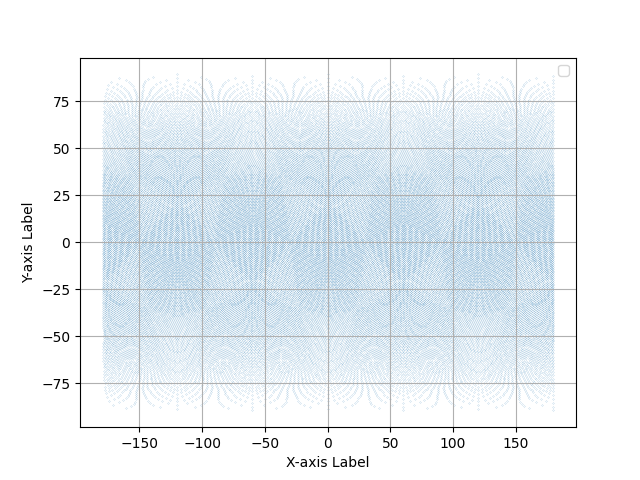

In [67]:
%matplotlib widget

plt.figure()
plt.scatter(g2m_graph.ndata["lat_lon"]["mesh"][:, 1], g2m_graph.ndata["lat_lon"]["mesh"][:, 0], s=0.01)
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.legend()
plt.grid(True)
plt.show()

**Comment:** Generate a bipartite graph between the lat-lon 2D grid and the mesh generated earlier.

## create_m2g_graph()

In [139]:
cartesian_grid = latlon2xyz(lat_lon_grid_flat)
cartesian_grid, cartesian_grid.shape

(tensor([[ 4.3711e-08,  1.9072e-10, -1.0000e+00],
         [ 4.3710e-08,  3.8144e-10, -1.0000e+00],
         [ 4.3708e-08,  5.7216e-10, -1.0000e+00],
         ...,
         [ 4.3710e-08, -3.8144e-10,  1.0000e+00],
         [ 4.3711e-08, -1.9072e-10,  1.0000e+00],
         [ 4.3711e-08,  3.8214e-15,  1.0000e+00]]),
 torch.Size([1038240, 3]))

In [144]:
face_centroids = get_face_centroids(mesh_vertices, mesh_faces)
face_centroids[:5], len(face_centroids)

([(0.2648848096529643, 0.45879395802815753, 0.5923004150390625),
  (-0.1011769970258077, 0.7423442204793295, 0.2648848096529643),
  (0.693477471669515, 0.2835502624511719, 0.2648848096529643),
  (0.5923004547754923, 0.45879395802815753, -0.2648848096529643),
  (0.693477471669515, -0.2835502624511719, 0.2648848096529643)],
 109220)

In [146]:
n_nbrs = 1
neighbors = NearestNeighbors(n_neighbors=n_nbrs).fit(face_centroids)
_, indices = neighbors.kneighbors(cartesian_grid)
indices = indices.flatten()
indices, len(indices)

(array([76451, 76451, 76451, ..., 55971, 55971, 55971]), 1038240)

**Comment:** For each point in the lat/lon grid, a face is identified. But there are several overlapping surfaces: how is this managed?

In [151]:
src = [p for i in indices for p in mesh_faces[i]]
dst = [i for i in range(len(cartesian_grid)) for _ in range(3)]

src[:5], len(src), dst[:5], len(dst)

([28832, 28833, 28831, 28832, 28833], 3114720, [0, 0, 0, 1, 1], 3114720)

In [152]:
m2g_graph = create_heterograph(
    src, dst, ("mesh", "m2g", "grid"), dtype=torch.int32
) # number of edges is 3,114,720, exactly matches with the paper

In [184]:
m2g_graph.srcdata["pos"] = torch.tensor(
    mesh_vertices,
    dtype=torch.float32,
)
m2g_graph.dstdata["pos"] = cartesian_grid.to(dtype=torch.float32)
m2g_graph.srcdata["lat_lon"] = xyz2latlon(m2g_graph.srcdata["pos"])
m2g_graph.dstdata["lat_lon"] = lat_lon_grid_flat

m2g_graph = add_edge_features(
    m2g_graph, (m2g_graph.srcdata["pos"], m2g_graph.dstdata["pos"])
)

In [185]:
m2g_graph

Graph(num_nodes={'grid': 1038240, 'mesh': 40962},
      num_edges={('mesh', 'm2g', 'grid'): 3114720},
      metagraph=[('mesh', 'grid', 'm2g')])

In [186]:
_src_node = m2g_graph.srcnodes[0]
_src_node

NodeSpace(data={'pos': tensor([[0.4911, 0.8507, 0.1876]]), 'lat_lon': tensor([[10.8123, 60.0000]])})

In [191]:
successors = m2g_graph.successors(0)
successors

tensor([576958, 576959, 576960, 578397, 578398, 578399, 578400, 578401, 579836,
        579837, 579838, 579839, 579840, 579841, 579842, 581276, 581277, 581278,
        581279, 581280, 581281, 581282, 582716, 582717, 582718, 582719, 582720,
        582721, 582722, 584157, 584158, 584159, 584160, 584161, 585597, 585598,
        585599, 585600, 585601], dtype=torch.int32)

In [194]:
successor_pos = m2g_graph.ndata["pos"]["grid"][successors]
successor_pos

tensor([[0.4961, 0.8507, 0.1736],
        [0.4924, 0.8529, 0.1736],
        [0.4887, 0.8550, 0.1736],
        [0.4994, 0.8479, 0.1779],
        [0.4957, 0.8500, 0.1779],
        [0.4920, 0.8522, 0.1779],
        [0.4883, 0.8543, 0.1779],
        [0.4846, 0.8565, 0.1779],
        [0.5027, 0.8450, 0.1822],
        [0.4990, 0.8472, 0.1822],
        [0.4953, 0.8494, 0.1822],
        [0.4916, 0.8515, 0.1822],
        [0.4879, 0.8537, 0.1822],
        [0.4842, 0.8558, 0.1822],
        [0.4804, 0.8579, 0.1822],
        [0.5023, 0.8443, 0.1865],
        [0.4986, 0.8465, 0.1865],
        [0.4949, 0.8487, 0.1865],
        [0.4912, 0.8508, 0.1865],
        [0.4875, 0.8530, 0.1865],
        [0.4838, 0.8551, 0.1865],
        [0.4800, 0.8572, 0.1865],
        [0.5019, 0.8436, 0.1908],
        [0.4982, 0.8458, 0.1908],
        [0.4945, 0.8480, 0.1908],
        [0.4908, 0.8501, 0.1908],
        [0.4871, 0.8522, 0.1908],
        [0.4834, 0.8544, 0.1908],
        [0.4796, 0.8565, 0.1908],
        [0.497

In [205]:
_src_node.data["pos"]

tensor([[0.4911, 0.8507, 0.1876]])

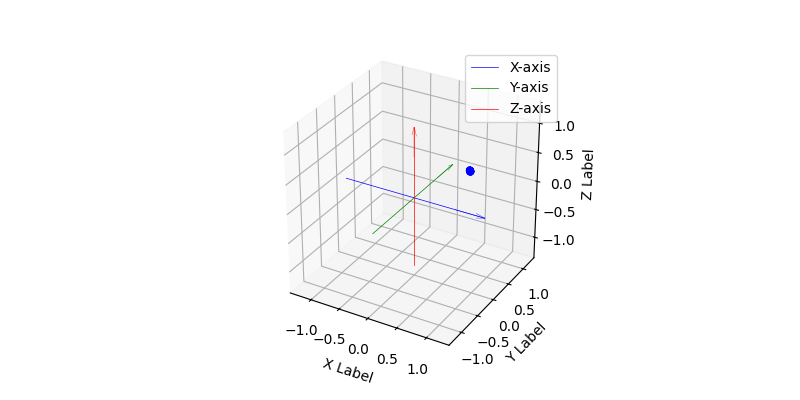

In [208]:
%matplotlib widget

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111, projection='3d')

# Add thin X, Y, Z axis lines
v_range = [-1.2, 1.2]
ax.plot(v_range, [0, 0], [0, 0], color='blue', linewidth=.5, label='X-axis')
ax.plot([0, 0], v_range, [0, 0], color='green', linewidth=.5, label='Y-axis')
ax.plot([0, 0], [0, 0], v_range, color='red', linewidth=.5, label='Z-axis')
# Add small arrows at the end of each axis
arrow_length = 0.5
arrow_starts = v_range[-1] - arrow_length
ax.quiver(arrow_starts, 0, 0, arrow_length, 0, 0, color='blue', linewidth=.25)
ax.quiver(0, arrow_starts, 0, 0, arrow_length, 0, color='green', linewidth=.25)
ax.quiver(0, 0, arrow_starts, 0, 0, arrow_length, color='red', linewidth=.25)

# Plot data
_point = _src_node.data["pos"][0]
ax.scatter3D(_point[0], _point[1], _point[2], color='green')
ax.scatter3D(successor_pos[:, 0], successor_pos[:, 1], successor_pos[:, 2], color='blue')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_aspect('equal')
ax.legend()
plt.show()

In [217]:
successor_pos = m2g_graph.ndata["lat_lon"]["grid"][successors]
successor_pos

tensor([[10.0000, 59.7500],
        [10.0000, 60.0000],
        [10.0000, 60.2500],
        [10.2500, 59.5000],
        [10.2500, 59.7500],
        [10.2500, 60.0000],
        [10.2500, 60.2500],
        [10.2500, 60.5000],
        [10.5000, 59.2500],
        [10.5000, 59.5000],
        [10.5000, 59.7500],
        [10.5000, 60.0000],
        [10.5000, 60.2500],
        [10.5000, 60.5000],
        [10.5000, 60.7500],
        [10.7500, 59.2500],
        [10.7500, 59.5000],
        [10.7500, 59.7500],
        [10.7500, 60.0000],
        [10.7500, 60.2500],
        [10.7500, 60.5000],
        [10.7500, 60.7500],
        [11.0000, 59.2500],
        [11.0000, 59.5000],
        [11.0000, 59.7500],
        [11.0000, 60.0000],
        [11.0000, 60.2500],
        [11.0000, 60.5000],
        [11.0000, 60.7500],
        [11.2500, 59.5000],
        [11.2500, 59.7500],
        [11.2500, 60.0000],
        [11.2500, 60.2500],
        [11.2500, 60.5000],
        [11.5000, 59.5000],
        [11.5000, 59

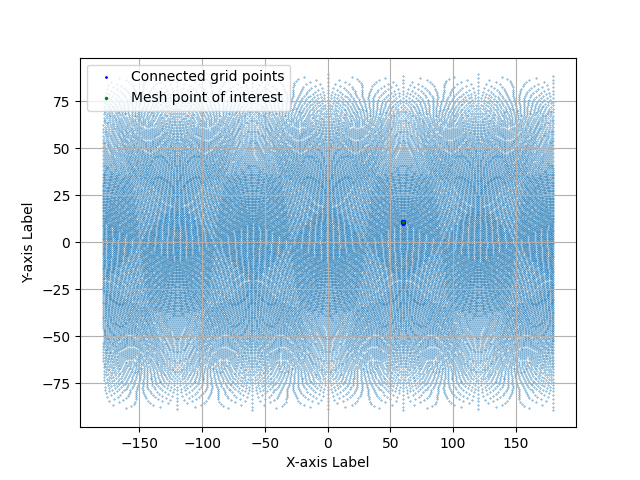

In [226]:
%matplotlib widget

plt.figure()
plt.scatter(g2m_graph.ndata["lat_lon"]["mesh"][:, 1], g2m_graph.ndata["lat_lon"]["mesh"][:, 0], s=0.1)

plt.scatter(successor_pos[:, 1], successor_pos[:, 0], color='blue', s=1, label='Connected grid points')

_point = _src_node.data["lat_lon"][0]
plt.scatter(_point[1], _point[0], s=2, color='green', label='Mesh point of interest')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.legend()
plt.grid(True)
plt.show()

## cugraphops stuff

Currently skipped. Will be looked at later.